<a href="https://colab.research.google.com/github/leonardevop/mvp_1/blob/main/notebook_mvp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Este notebook é um produto apresentado como trabalho de conclusão do primeiro módulo do MBA de Ciência de Dados, ministrado pela PUC-RJ e construído em maio de 2023, do aluno **Leonard Ravaglia Pereira**.

# Definição do problema

Os orçamentos públicos dos entes federativos contém a projeção de receitas do ano respectivo, e a partir delas são planejadas as despesas públicas desse mesmo ano. É sempre um desafio para os gestores públicos prever os valores realizáveis dessas receitas, dadas as variáveis que afetam a arrecadação.

Este trabalho pretende apresentar um modelo supervisionado de regressão que auxilie a projeção das receitas tributárias para os anos seguintes, baseado no histórico de arrecadação dos tributos, por estado.

Nossa hipótese inicial é de que perfil do crescimento ou redução de cada tributo ao passar dos anos possa indicar os efeitos na arrecadação dos anos seguintes.

Para isso, será utilizado um dataset extraído do [portal de dados abertos](hhttps://dados.gov.br/dados/conjuntos-dados/resultado-da-arrecadacao) do governo federal. Partimos do pressuposto de que as informações nele contidas, foram aprovados pelos tribunais de contas e que são os dados oficiais de cada estado.

Os dados do dataset estão atualizados até março de 2023, mas dada a proposta de projeção de receitas para o ano, serão considerados apenas os dados até dezembro de 2022. Em virtude da pandemia e os seus efeitos econômicos, o comportamento dos dados de 2020 e 2021 farão parte do teste, porém poderão serem avaliados em separado.


In [268]:

#Importando bibliotecas que serão utilizadas no trabalho
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import missingno as ms
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 

# Análise de Dados

Carregando o dataset extraído do portal de dados abertos e replicado para o depositório do Github.

Foi utilizado encoding cp1252 após inconsistências na leitura com o padrão utf-8.

In [269]:
#Definindo path do dataset
url_dados: str = 'https://raw.githubusercontent.com/leonardevop/mvp_1/main/arrecadacao-estado%20(1).csv'

arrecadacao = pd.read_csv(url_dados, delimiter=';', encoding='cp1252')
#Avaliando o conjunto completo do dataframe carregado
arrecadacao


,Ano,Mês,UF,IMPOSTO SOBRE IMPORTAÇÃO,IMPOSTO SOBRE EXPORTAÇÃO,IPI - FUMO,IPI - BEBIDAS,IPI - AUTOMÓVEIS,IPI - VINCULADO À IMPORTACAO,IPI - OUTROS,...,REFIS,PAES,RETENÇÃO NA FONTE - LEI 10.833 Art. 30,PAGAMENTO UNIFICADO,OUTRAS RECEITAS ADMINISTRADAS,DEMAIS RECEITAS,RECEITA PREVIDENCIÁRIA,RECEITA PREVIDENCIÁRIA - PRÓPRIA,RECEITA PREVIDENCIÁRIA - DEMAIS,ADMINISTRADAS POR OUTROS ÓRGÃOS
0,2000,Janeiro,AC,231,0,292096,0,0,167,1558,...,NaN,NaN,NaN,NaN,20911,NaN,NaN,NaN,NaN,NaN
1,2000,Janeiro,AL,475088,33873,1329338,812470,0,141735,3676847,...,NaN,NaN,NaN,NaN,127189,NaN,NaN,NaN,NaN,NaN
2,2000,Janeiro,AM,11679405,0,1507146,1791471,27796,4414483,1800346,...,NaN,NaN,NaN,NaN,187988,NaN,NaN,NaN,NaN,NaN
3,2000,Janeiro,AP,24267,0,424862,1419,321,22333,12165,...,NaN,NaN,NaN,NaN,10769,NaN,NaN,NaN,NaN,NaN
4,2000,Janeiro,BA,10476457,13,5542123,11533707,0,7496476,23743858,...,NaN,NaN,NaN,NaN,536498,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7528,2023,Março,RS,15836217,0,0,0,0,2420866,23524606,...,NaN,NaN,NaN,NaN,56294066,NaN,6.874600e+09,NaN,NaN,1.065146e+09
7529,2023,Março,SC,1002120548,858532,0,897532412,3011745881,3881102956,3720682797,...,NaN,NaN,NaN,NaN,8971306055,NaN,2.420498e+09,NaN,NaN,2.907057e+09
7530,2023,Março,SE,1792437623,-1309421,231803776,451808802,1839273499,6451088764,1033460741,...,NaN,NaN,NaN,NaN,1480417865,NaN,1.779441e+10,NaN,NaN,2.574332e+08
7531,2023,Março,SP,379440024,214698413,37450835,203994968,0,11139877,657689162,...,NaN,NaN,NaN,NaN,380583903,NaN,2.347739e+09,NaN,NaN,3.542186e+09


Agora, veremos a distribuição dos tipos de dados dos atributos do dataset, para verificação de eventuais inconsistências.

In [270]:
#Verificando os tipos de dados de cada coluna do dataframe
arrecadacao.dtypes

Ano                                                               int64
Mês                                                              object
UF                                                               object
IMPOSTO SOBRE IMPORTAÇÃO                                          int64
IMPOSTO SOBRE EXPORTAÇÃO                                          int64
IPI - FUMO                                                        int64
IPI - BEBIDAS                                                     int64
IPI - AUTOMÓVEIS                                                  int64
IPI - VINCULADO À IMPORTACAO                                      int64
IPI - OUTROS                                                      int64
IRPF                                                              int64
IRPJ - ENTIDADES FINANCEIRAS                                      int64
IRPJ - DEMAIS EMPRESAS                                            int64
IRRF - RENDIMENTOS DO TRABALHO                                  

Dado que o dataset está voltado para a apresentação de valores, o resultado é condizente com o esperado.

Observa-se duas colunas categóricas, "Mês" e "UF", que demandarão uma avaliação para checagem dos padrões de texto e se deverão ser tratados.

A variação entre colunas de integers e floats indicam que há atributos que possuem valor decimal. A depender o volume, os tipos poderão ser mantidos, ou uniformizados como inteiros.

Agora, veremos o conjunto das 10 primeiras linhas do dataset.

In [271]:
#Consultando os 10 primeiros registros do dataframe
arrecadacao.head(10)

,Ano,Mês,UF,IMPOSTO SOBRE IMPORTAÇÃO,IMPOSTO SOBRE EXPORTAÇÃO,IPI - FUMO,IPI - BEBIDAS,IPI - AUTOMÓVEIS,IPI - VINCULADO À IMPORTACAO,IPI - OUTROS,...,REFIS,PAES,RETENÇÃO NA FONTE - LEI 10.833 Art. 30,PAGAMENTO UNIFICADO,OUTRAS RECEITAS ADMINISTRADAS,DEMAIS RECEITAS,RECEITA PREVIDENCIÁRIA,RECEITA PREVIDENCIÁRIA - PRÓPRIA,RECEITA PREVIDENCIÁRIA - DEMAIS,ADMINISTRADAS POR OUTROS ÓRGÃOS
0,2000,Janeiro,AC,231,0,292096,0,0,167,1558,...,NaN,NaN,NaN,NaN,20911,NaN,NaN,NaN,NaN,NaN
1,2000,Janeiro,AL,475088,33873,1329338,812470,0,141735,3676847,...,NaN,NaN,NaN,NaN,127189,NaN,NaN,NaN,NaN,NaN
2,2000,Janeiro,AM,11679405,0,1507146,1791471,27796,4414483,1800346,...,NaN,NaN,NaN,NaN,187988,NaN,NaN,NaN,NaN,NaN
3,2000,Janeiro,AP,24267,0,424862,1419,321,22333,12165,...,NaN,NaN,NaN,NaN,10769,NaN,NaN,NaN,NaN,NaN
4,2000,Janeiro,BA,10476457,13,5542123,11533707,0,7496476,23743858,...,NaN,NaN,NaN,NaN,536498,NaN,NaN,NaN,NaN,NaN
5,2000,Janeiro,CE,5576921,0,4535653,3148254,0,1734529,3716458,...,NaN,NaN,NaN,NaN,143952,NaN,NaN,NaN,NaN,NaN
6,2000,Janeiro,DF,2254341,43,3197500,2777942,0,2079272,2433339,...,NaN,NaN,NaN,NaN,33937318,NaN,NaN,NaN,NaN,NaN
7,2000,Janeiro,ES,31950799,0,3598736,20408,1503039,26840430,4036463,...,NaN,NaN,NaN,NaN,382985,NaN,NaN,NaN,NaN,NaN
8,2000,Janeiro,GO,3747911,0,3236092,5064141,1091185,986314,2654994,...,NaN,NaN,NaN,NaN,403579,NaN,NaN,NaN,NaN,NaN
9,2000,Janeiro,MA,1714749,69,1124738,4061569,0,206691,484436,...,NaN,NaN,NaN,NaN,121337,NaN,NaN,NaN,NaN,NaN


Percebe-se que há atributos sem valores. Dado que o ano inicial do dataset é em 2000, a ausência de valores nos registros podem indicar a inclusão de tipos de receitas em períodos posteriores ou adaptação dos estados ao processo de prestação das informações.

Observa-se ainda que o dataset possui 45 atributos, o que pode gerar a necessidade de agregação deles.

Nesse ponto, avaliaremos os últimos registros do dataset, para compará-lo aos registros iniciais e verificar alterações ao longo da amostra.

In [272]:
#Consultando os últimos 10 registros no dataframe
arrecadacao.tail(10)

,Ano,Mês,UF,IMPOSTO SOBRE IMPORTAÇÃO,IMPOSTO SOBRE EXPORTAÇÃO,IPI - FUMO,IPI - BEBIDAS,IPI - AUTOMÓVEIS,IPI - VINCULADO À IMPORTACAO,IPI - OUTROS,...,REFIS,PAES,RETENÇÃO NA FONTE - LEI 10.833 Art. 30,PAGAMENTO UNIFICADO,OUTRAS RECEITAS ADMINISTRADAS,DEMAIS RECEITAS,RECEITA PREVIDENCIÁRIA,RECEITA PREVIDENCIÁRIA - PRÓPRIA,RECEITA PREVIDENCIÁRIA - DEMAIS,ADMINISTRADAS POR OUTROS ÓRGÃOS
7523,2023,Março,PR,792552179,162027,0,131724015,0,371217352,270807955,...,NaN,NaN,NaN,NaN,335445508,NaN,2.987113e+08,NaN,NaN,4.870815e+09
7524,2023,Março,RJ,2510281987,99667,64486121,1902391878,3120301205,1334851511,8365272065,...,NaN,NaN,NaN,NaN,3885428019,NaN,3.995837e+09,NaN,NaN,4.477230e+09
7525,2023,Março,RN,943268215,-148,0,22832056,445022,253886589,455311037,...,NaN,NaN,NaN,NaN,530786834,NaN,4.689384e+09,NaN,NaN,1.388955e+09
7526,2023,Março,RO,1476999897,646176,165734858,986671244,1596547,1177773114,1797631537,...,NaN,NaN,NaN,NaN,5897926479,NaN,2.883040e+09,NaN,NaN,4.303926e+09
7527,2023,Março,RR,3062256007,-1569,0,17857302,65767,1084254176,596135663,...,NaN,NaN,NaN,NaN,504771452,NaN,2.123918e+09,NaN,NaN,2.997187e+09
7528,2023,Março,RS,15836217,0,0,0,0,2420866,23524606,...,NaN,NaN,NaN,NaN,56294066,NaN,6.874600e+09,NaN,NaN,1.065146e+09
7529,2023,Março,SC,1002120548,858532,0,897532412,3011745881,3881102956,3720682797,...,NaN,NaN,NaN,NaN,8971306055,NaN,2.420498e+09,NaN,NaN,2.907057e+09
7530,2023,Março,SE,1792437623,-1309421,231803776,451808802,1839273499,6451088764,1033460741,...,NaN,NaN,NaN,NaN,1480417865,NaN,1.779441e+10,NaN,NaN,2.574332e+08
7531,2023,Março,SP,379440024,214698413,37450835,203994968,0,11139877,657689162,...,NaN,NaN,NaN,NaN,380583903,NaN,2.347739e+09,NaN,NaN,3.542186e+09
7532,2023,Março,TO,24659064,0,0,32331297,0,168231541,140113866,...,NaN,NaN,NaN,NaN,23348497,NaN,1.952184e+09,NaN,NaN,2.955795e+09


Identificado que os últimos registros indicam que os dados foram atualizados até Março de 2023.

Alguns atributos permanecem sem registros, podendo indicar um tipo de arrecadação temporária, ou desatualização da prestação das informações pelos estados, tendo em vista que tratam-se de datas mais recentes.

Outros, contém valores não apresentados no início do dataset, indicando o seu registro em período posterior ao início da coleta das informações, ao eventuais mudanças de critério de cálculo.

Além disso, verifica-se que há 7533 linhas no dataframe.

Para obter uma visão mais específica dos atributos mantidos no dataset, cabe avaliar as lista de todas as colunas.

In [273]:
#Consultando a lista das 45 colunas do dataframe
arrecadacao.columns

Index(['Ano', 'Mês', 'UF', 'IMPOSTO SOBRE IMPORTAÇÃO',
       'IMPOSTO SOBRE EXPORTAÇÃO', 'IPI - FUMO', 'IPI - BEBIDAS',
       'IPI - AUTOMÓVEIS', 'IPI - VINCULADO À IMPORTACAO', 'IPI - OUTROS',
       'IRPF', 'IRPJ - ENTIDADES FINANCEIRAS', 'IRPJ - DEMAIS EMPRESAS',
       'IRRF - RENDIMENTOS DO TRABALHO', 'IRRF - RENDIMENTOS DO CAPITAL',
       'IRRF - REMESSAS P/ EXTERIOR', 'IRRF - OUTROS RENDIMENTOS',
       'IMPOSTO S/ OPERAÇÕES FINANCEIRAS', 'IMPOSTO TERRITORIAL RURAL',
       'IMPOSTO PROVIS.S/ MOVIMENT. FINANC. - IPMF', 'CPMF', 'COFINS',
       'COFINS - FINANCEIRAS', 'COFINS - DEMAIS',
       'CONTRIBUIÇÃO PARA O PIS/PASEP',
       'CONTRIBUIÇÃO PARA O PIS/PASEP - FINANCEIRAS',
       'CONTRIBUIÇÃO PARA O PIS/PASEP - DEMAIS', 'CSLL', 'CSLL - FINANCEIRAS',
       'CSLL - DEMAIS', 'CIDE-COMBUSTÍVEIS (parc. não dedutível)',
       'CIDE-COMBUSTÍVEIS', 'CONTRIBUIÇÃO PLANO SEG. SOC. SERVIDORES',
       'CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público',
       'CONTRIB

Conseguimos identificar que há segregações do mesmo imposto em diferentes categorias.

Também, verificamos mais indícios de colunas que podem conter subtotais das colunas segregadas, ou mudanças de critérios de totalização dos valores ao longo do tempo.

Assim, vamos revisar as dimensões no dataframe.

In [274]:
#Confirmando dimensões do dataframe
arrecadacao.shape

(7533, 45)

As dimensões identificadas anteriormente forma confirmadas.

Nessa etapa, vamos verificar a quantidades de registros válidos no dataset, para identificar possíveis missings.

In [275]:
#Verificando o total de registros por cada coluna do dataframe
arrecadacao.count()

Ano                                                             7533
Mês                                                             7533
UF                                                              7533
IMPOSTO SOBRE IMPORTAÇÃO                                        7533
IMPOSTO SOBRE EXPORTAÇÃO                                        7533
IPI - FUMO                                                      7533
IPI - BEBIDAS                                                   7533
IPI - AUTOMÓVEIS                                                7533
IPI - VINCULADO À IMPORTACAO                                    7533
IPI - OUTROS                                                    7533
IRPF                                                            7533
IRPJ - ENTIDADES FINANCEIRAS                                    7533
IRPJ - DEMAIS EMPRESAS                                          7533
IRRF - RENDIMENTOS DO TRABALHO                                  7533
IRRF - RENDIMENTOS DO CAPITAL     

Identificado que apenas algumas colunas possuem registros em todas as linhas, porém há um grupo grande de atributos sem registros.

Ainda não é possível identificar o motivo da ausência dos registros, mas já é possível identificar que há segregação, pois o total de registros nos atributos segregados somado a colunas agregadoras equivale ao total das linhas do dataset.

Em outros casos, será necessário mais investigação.

Dessas primeiras interpretações, fazemos um exercício de avaliação das estatísticas do dataset como um todo, para termos uma métricas de referência inicial.

In [276]:
#Obtendo um resumo das informações do dataframe
arrecadacao.describe()

,Ano,IMPOSTO SOBRE IMPORTAÇÃO,IMPOSTO SOBRE EXPORTAÇÃO,IPI - FUMO,IPI - BEBIDAS,IPI - AUTOMÓVEIS,IPI - VINCULADO À IMPORTACAO,IPI - OUTROS,IRPF,IRPJ - ENTIDADES FINANCEIRAS,...,REFIS,PAES,RETENÇÃO NA FONTE - LEI 10.833 Art. 30,PAGAMENTO UNIFICADO,OUTRAS RECEITAS ADMINISTRADAS,DEMAIS RECEITAS,RECEITA PREVIDENCIÁRIA,RECEITA PREVIDENCIÁRIA - PRÓPRIA,RECEITA PREVIDENCIÁRIA - DEMAIS,ADMINISTRADAS POR OUTROS ÓRGÃOS
count,7533.000000,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,...,3.240000e+02,3.240000e+02,2.700000e+02,3.780000e+02,7.533000e+03,2.160000e+03,1.971000e+03,1.431000e+03,1.431000e+03,4.077000e+03
mean,2011.129032,1.034112e+09,3.202691e+06,1.718195e+08,4.160473e+08,3.366193e+08,8.444121e+08,8.956928e+08,1.369203e+09,5.062470e+08,...,2.163363e+06,8.472560e+06,1.295935e+07,9.749743e+06,9.241200e+08,5.956634e+08,4.039714e+09,2.350958e+09,1.994049e+09,2.617280e+09
std,6.713017,2.091124e+09,2.543243e+07,8.290416e+08,1.039016e+09,1.148168e+09,1.925163e+09,1.947720e+09,2.091944e+09,1.359094e+09,...,3.904852e+06,1.657378e+07,3.508999e+07,1.876911e+07,1.840472e+09,1.495395e+09,3.195786e+09,2.657790e+09,2.428874e+09,2.700646e+09
min,2000.000000,-1.792566e+07,-9.155959e+07,-4.329186e+08,-1.079723e+07,-1.454896e+08,0.000000e+00,-3.485777e+08,1.228300e+04,-8.099953e+08,...,-1.797889e+06,1.360000e+05,9.309000e+03,1.161950e+05,-1.991267e+10,-1.974837e+07,3.446879e+07,2.256750e+07,1.270067e+06,-5.810897e+09
25%,2005.000000,1.357881e+06,0.000000e+00,0.000000e+00,2.124144e+06,0.000000e+00,4.664470e+05,3.000652e+06,8.080265e+06,3.207400e+04,...,2.972922e+05,1.179268e+06,5.177198e+05,1.236024e+06,1.964925e+06,2.468620e+06,1.812181e+09,3.749883e+08,4.787868e+07,3.833357e+08
50%,2011.000000,3.249109e+07,3.074000e+03,6.235990e+05,1.801698e+07,6.069000e+03,2.077800e+07,9.389117e+07,3.090043e+08,3.252555e+06,...,7.620455e+05,2.561976e+06,2.529214e+06,2.937894e+06,1.032554e+08,2.374454e+07,3.114104e+09,1.531095e+09,1.277967e+09,1.765880e+09
75%,2017.000000,9.299352e+08,2.303110e+05,5.832567e+06,3.025808e+08,6.402158e+06,3.649608e+08,6.949584e+08,1.907351e+09,1.527524e+08,...,2.336568e+06,6.589126e+06,8.767503e+06,8.698714e+06,9.923987e+08,3.478209e+08,5.554899e+09,3.175925e+09,2.977983e+09,3.929632e+09
max,2023.000000,9.978470e+09,1.557215e+09,9.904761e+09,9.945420e+09,9.967381e+09,9.990833e+09,9.996958e+09,9.999580e+09,9.940508e+09,...,2.458967e+07,8.532303e+07,2.138863e+08,1.032222e+08,2.289754e+10,9.938066e+09,2.778681e+10,1.949341e+10,9.889055e+09,2.247643e+10


Verificado que há valores mínimos negativos em algumas colunas. Esses valores podem significar créditos cedidos ao contribuinte em volume maior do que valor recolhido, ou preenchimentos efetivamente incorretos.

Vamos alterar a ordem dos atributos do dataset para verificar se isso auxiliará a obtenção de insights.

In [277]:
#Alterando a ordem da distribuição por UF, Ano e Mês
arrecadacao.sort_values(by=['UF', 'Ano', 'Mês'])


,Ano,Mês,UF,IMPOSTO SOBRE IMPORTAÇÃO,IMPOSTO SOBRE EXPORTAÇÃO,IPI - FUMO,IPI - BEBIDAS,IPI - AUTOMÓVEIS,IPI - VINCULADO À IMPORTACAO,IPI - OUTROS,...,REFIS,PAES,RETENÇÃO NA FONTE - LEI 10.833 Art. 30,PAGAMENTO UNIFICADO,OUTRAS RECEITAS ADMINISTRADAS,DEMAIS RECEITAS,RECEITA PREVIDENCIÁRIA,RECEITA PREVIDENCIÁRIA - PRÓPRIA,RECEITA PREVIDENCIÁRIA - DEMAIS,ADMINISTRADAS POR OUTROS ÓRGÃOS
81,2000,Abril,AC,69,0,281844,0,0,53,15332,...,NaN,NaN,NaN,NaN,16011,NaN,NaN,NaN,NaN,NaN
189,2000,Agosto,AC,514,0,278217,0,0,0,12191,...,NaN,NaN,NaN,NaN,53755,NaN,NaN,NaN,NaN,NaN
297,2000,Dezembro,AC,784,0,313571,0,0,111,7409,...,NaN,NaN,NaN,NaN,38439,NaN,NaN,NaN,NaN,NaN
27,2000,Fevereiro,AC,441,0,255361,0,0,0,11437,...,NaN,NaN,NaN,NaN,21142,NaN,NaN,NaN,NaN,NaN
0,2000,Janeiro,AC,231,0,292096,0,0,167,1558,...,NaN,NaN,NaN,NaN,20911,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7397,2022,Outubro,TO,35,49347,0,913183,0,0,188935471,...,NaN,NaN,NaN,NaN,397732912,NaN,1.930621e+08,NaN,NaN,1.337500e+09
7370,2022,Setembro,TO,84315,2732,0,18089442,0,48994066,236816107,...,NaN,NaN,NaN,NaN,544496168,NaN,1.955863e+09,NaN,NaN,3.669632e+09
7505,2023,Fevereiro,TO,329789178,-4,0,36343944,686202,108584577,97787379,...,NaN,NaN,NaN,NaN,5169123,NaN,1.837454e+09,NaN,NaN,2.698647e+09
7478,2023,Janeiro,TO,317412404,-44,0,37682617,0,162485421,108892604,...,NaN,NaN,NaN,NaN,207209162,NaN,2.040047e+09,NaN,NaN,2.675652e+09


A ordenação com a utilização de atributos categóricos atrapalha o entendimento da distribuição e possíveis agrupamentos de atributos.

Com isso, podemos pensar na possiblidade de conversão do atributo mês para um formato numérico.

Nesse ponto, vejamos alguns casos de possívels atributos que poderiam ser agregados, ou se há subtotalizações.

In [278]:
#Verificando segregações das coluinas de IPI para checar se há subtotalizações, analisando todas as linhas.
arrecadacao.loc[:, ['IPI - FUMO', 'IPI - BEBIDAS', 'IPI - AUTOMÓVEIS', 'IPI - VINCULADO À IMPORTACAO', 'IPI - OUTROS']]

,IPI - FUMO,IPI - BEBIDAS,IPI - AUTOMÓVEIS,IPI - VINCULADO À IMPORTACAO,IPI - OUTROS
0,292096,0,0,167,1558
1,1329338,812470,0,141735,3676847
2,1507146,1791471,27796,4414483,1800346
3,424862,1419,321,22333,12165
4,5542123,11533707,0,7496476,23743858
...,...,...,...,...,...
7528,0,0,0,2420866,23524606
7529,0,897532412,3011745881,3881102956,3720682797
7530,231803776,451808802,1839273499,6451088764,1033460741
7531,37450835,203994968,0,11139877,657689162



Não identificadas subtotalizações, mas aparentemente, informações inconsistentes, tais como arrecadação zerada de IPI para Fumo e Bebidas, que dificilmente terão isenção de IPI.

À princípio, entendemos que esses atributos poderão ser agregados, dado que o a previsão de arrecadação pode ser analisada e tratada para o tributo como um todo e não por suas divisões.

Vamos repetir essa avaliação para o tributo COFINS.

In [279]:
#Verificando segregações das colunas de COFINS para checar se há subtotalizações, analisando todas as linhas.
arrecadacao.loc[:,['Ano', 'Mês', 'UF','COFINS', 'COFINS - FINANCEIRAS', 'COFINS - DEMAIS']]

,Ano,Mês,UF,COFINS,COFINS - FINANCEIRAS,COFINS - DEMAIS
0,2000,Janeiro,AC,1770475.0,NaN,NaN
1,2000,Janeiro,AL,7493570.0,NaN,NaN
2,2000,Janeiro,AM,44000981.0,NaN,NaN
3,2000,Janeiro,AP,1682102.0,NaN,NaN
4,2000,Janeiro,BA,81027229.0,NaN,NaN
...,...,...,...,...,...,...
7528,2023,Março,RS,NaN,8.803350e+05,1.617155e+09
7529,2023,Março,SC,NaN,2.588785e+08,2.008501e+09
7530,2023,Março,SE,NaN,1.295632e+09,9.767005e+09
7531,2023,Março,SP,NaN,2.195049e+08,6.062310e+09



Identificada que a distribuição inicial não contém valores para os atributos detalhados de COFINS, e o específico contém. Nas finais, essa relação se inverte, mantendo valores nas colunas de detalhamento e não contendo registros para a coluna específica do tributo.

Aparentemente, podemos deduzir que não há subtotalização e que houve uma mudança de critério de arrecadação em um determinado período, onde os códigos para recolhimento da COFINS podem ter sido segregados.

Em princípio, não há restrições para que as colunas possam ser agregadas.

Vamos repetir a mesma análise para os dados de Previdência.

In [280]:
#Verificando segregações das colunas de Receita Previdenciária para checar se há subtotalizações, analisando todas as linhas.
arrecadacao.loc[:,['Ano', 'Mês', 'UF','RECEITA PREVIDENCIÁRIA', 'RECEITA PREVIDENCIÁRIA - PRÓPRIA', 'RECEITA PREVIDENCIÁRIA - DEMAIS', 'ADMINISTRADAS POR OUTROS ÓRGÃOS']]

,Ano,Mês,UF,RECEITA PREVIDENCIÁRIA,RECEITA PREVIDENCIÁRIA - PRÓPRIA,RECEITA PREVIDENCIÁRIA - DEMAIS,ADMINISTRADAS POR OUTROS ÓRGÃOS
0,2000,Janeiro,AC,NaN,NaN,NaN,NaN
1,2000,Janeiro,AL,NaN,NaN,NaN,NaN
2,2000,Janeiro,AM,NaN,NaN,NaN,NaN
3,2000,Janeiro,AP,NaN,NaN,NaN,NaN
4,2000,Janeiro,BA,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
7528,2023,Março,RS,6.874600e+09,NaN,NaN,1.065146e+09
7529,2023,Março,SC,2.420498e+09,NaN,NaN,2.907057e+09
7530,2023,Março,SE,1.779441e+10,NaN,NaN,2.574332e+08
7531,2023,Março,SP,2.347739e+09,NaN,NaN,3.542186e+09


Identificado que há ausência de informações nos primeiros períodos e, em alguns casos, também  para o final.

Não é possível identificar o motivo da segregação, mas percebe-se que apenas dois atributos são atualmente considerados.

Façamos o mesmo exercício para a CSLL.

In [281]:
#Verificando segregações das colunas de Imposto de renda para checar se há subtotalizações, analisando todas as linhas.
arrecadacao.loc[:,['Ano', 'Mês', 'UF','CSLL', 'CSLL - FINANCEIRAS', 'CSLL - DEMAIS']]

,Ano,Mês,UF,CSLL,CSLL - FINANCEIRAS,CSLL - DEMAIS
0,2000,Janeiro,AC,392830.0,NaN,NaN
1,2000,Janeiro,AL,1775834.0,NaN,NaN
2,2000,Janeiro,AM,7652859.0,NaN,NaN
3,2000,Janeiro,AP,346964.0,NaN,NaN
4,2000,Janeiro,BA,15699282.0,NaN,NaN
...,...,...,...,...,...,...
7528,2023,Março,RS,NaN,7.853500e+04,7.270771e+08
7529,2023,Março,SC,NaN,3.442156e+08,2.777630e+09
7530,2023,Março,SE,NaN,1.886354e+09,2.964038e+09
7531,2023,Março,SP,NaN,2.434271e+08,2.701283e+09


Identificada que a distribuição inicial não contém valores para os atributos detalhados de CSLL e o específico contém. Nas finais, essa relação se inverte, mantendo valores nas colunas de detalhamento e não contendo registros para a coluna específica do tributo, repetindo o mesmo comportamento da COFINS.

Aparentemente, podemos deduzir que não há subtotalização e que houve uma mudança de critério de arrecadação em um determinado período, onde os códigos para recolhimento da CSLL podem ter sido segregados.

Em princípio, não há restrições para que as colunas possam ser agregadas.

Novamente, verificaremos os dados referentes ao PIS/PASEP 

In [282]:
#Verificando segregações das colunas de PIS/PASEP para checar se há subtotalizações, analisando todas as linhas.
arrecadacao.loc[:,['Ano', 'Mês', 'UF','CONTRIBUIÇÃO PARA O PIS/PASEP', 'CONTRIBUIÇÃO PARA O PIS/PASEP - FINANCEIRAS', 'CONTRIBUIÇÃO PARA O PIS/PASEP - DEMAIS']]

,Ano,Mês,UF,CONTRIBUIÇÃO PARA O PIS/PASEP,CONTRIBUIÇÃO PARA O PIS/PASEP - FINANCEIRAS,CONTRIBUIÇÃO PARA O PIS/PASEP - DEMAIS
0,2000,Janeiro,AC,387364.0,NaN,NaN
1,2000,Janeiro,AL,2545254.0,NaN,NaN
2,2000,Janeiro,AM,11671871.0,NaN,NaN
3,2000,Janeiro,AP,574124.0,NaN,NaN
4,2000,Janeiro,BA,23138894.0,NaN,NaN
...,...,...,...,...,...,...
7528,2023,Março,RS,NaN,1.430590e+05,8.165964e+08
7529,2023,Março,SC,NaN,4.240106e+07,4.968609e+08
7530,2023,Março,SE,NaN,2.413777e+09,2.479620e+09
7531,2023,Março,SP,NaN,3.634896e+07,2.429120e+09


Identificada que a distribuição inicial não contém valores para os atributos detalhados de PIS/PASEP, e o específico contém. Nas finais, essa relação se inverte, mantendo valores nas colunas de detalhamento e não contendo registros para a coluna específica do tributo, da mesma forma como os casos detectados anteriormente.

Aparentemente, podemos deduzir que não há subtotalização e que houve uma mudança de critério de arrecadação em um determinado período, onde os códigos para recolhimento do PIS/PASEP podem ter sido segregados.

Em princípio, não há restrições para que as colunas possam ser agregadas.

Concluímos essa análise com os dados de CIDE.

In [283]:
#Verificando segregações das colunas de CIDE para checar se há subtotalizações, analisando todas as linhas.
arrecadacao.loc[:,['Ano', 'Mês', 'UF','CIDE-COMBUSTÍVEIS', 'CIDE-COMBUSTÍVEIS (parc. não dedutível)']]

,Ano,Mês,UF,CIDE-COMBUSTÍVEIS,CIDE-COMBUSTÍVEIS (parc. não dedutível)
0,2000,Janeiro,AC,NaN,NaN
1,2000,Janeiro,AL,NaN,NaN
2,2000,Janeiro,AM,NaN,NaN
3,2000,Janeiro,AP,NaN,NaN
4,2000,Janeiro,BA,NaN,NaN
...,...,...,...,...,...
7528,2023,Março,RS,0.0,NaN
7529,2023,Março,SC,10131.0,NaN
7530,2023,Março,SE,16994662.0,NaN
7531,2023,Março,SP,0.0,NaN


Identificada que a distribuição inicial não contém valores para os atributos detalhados de CIDE, e o específico contém. Nas finais, essa relação se inverte, mantendo valores nas colunas de detalhamento e não contendo registros para a coluna específica do tributo, da mesma forma como os casos detectados anteriormente.

Aparentemente, podemos deduzir que não há subtotalização e que houve uma mudança de critério de arrecadação em um determinado período, onde os códigos para recolhimento do PIS/PASEP podem ter sido segregados.

Em princípio, não há restrições para que as colunas possam ser agregadas.

# Primeiro pré-processamento

Dada a inconsistência identificada em alguns dos dados, será necessário realizar o tratamento antecipado, para viablizar uma análise mais consistente dos indicadores.

Mas, antes, faremos o backup do dataset.

In [284]:
arrecadacao_backup = arrecadacao



> Preenchendo *missings*



Incialmente, para as colunas que identificamos a possibilidade de agregação, preencheremos os *missings* com o valor 0.

In [285]:
#Preenchendo missings com valor 0 nas colunas que serão agregadas
arrecadacao_backup['CSLL'] = arrecadacao_backup['CSLL'].fillna(0)
arrecadacao_backup['CSLL - DEMAIS'] = arrecadacao_backup['CSLL - DEMAIS'].fillna(0)
arrecadacao_backup['CSLL - FINANCEIRAS'] = arrecadacao_backup['CSLL - FINANCEIRAS'].fillna(0)
arrecadacao_backup['CONTRIBUIÇÃO PARA O PIS/PASEP'] = arrecadacao_backup['CONTRIBUIÇÃO PARA O PIS/PASEP'].fillna(0)
arrecadacao_backup['CONTRIBUIÇÃO PARA O PIS/PASEP - FINANCEIRAS'] = arrecadacao_backup['CONTRIBUIÇÃO PARA O PIS/PASEP - FINANCEIRAS'].fillna(0) 
arrecadacao_backup['CONTRIBUIÇÃO PARA O PIS/PASEP - DEMAIS'] = arrecadacao_backup['CONTRIBUIÇÃO PARA O PIS/PASEP - DEMAIS'].fillna(0)
arrecadacao_backup['COFINS'] = arrecadacao_backup['COFINS'].fillna(0) 
arrecadacao_backup['COFINS - FINANCEIRAS'] = arrecadacao_backup['COFINS - FINANCEIRAS'].fillna(0)
arrecadacao_backup['COFINS - DEMAIS'] = arrecadacao_backup['COFINS - DEMAIS'].fillna(0)
arrecadacao_backup['CIDE-COMBUSTÍVEIS'] = arrecadacao_backup['CIDE-COMBUSTÍVEIS'].fillna(0)
arrecadacao_backup['CIDE-COMBUSTÍVEIS (parc. não dedutível)'] = arrecadacao_backup['CIDE-COMBUSTÍVEIS (parc. não dedutível)'].fillna(0)

Nos casos dos registros que são realizados no período atual, que não foram realizados no período inicial e não representam subtotais, preencheremos os campos em branco com o valor da mediana.

In [286]:
#Preenchendo missings com a mediana para as colunas que iniciaram arrecadação em período posterior as demais receitas iniciais e ainda permanecem sendo arrecadadas
arrecadacao_backup['CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público'].fillna(arrecadacao_backup['CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público'].median(), inplace=True)
arrecadacao_backup['RECEITA PREVIDENCIÁRIA'].fillna(arrecadacao_backup['RECEITA PREVIDENCIÁRIA'].median(), inplace=True)
arrecadacao_backup['ADMINISTRADAS POR OUTROS ÓRGÃOS'].fillna(arrecadacao_backup['ADMINISTRADAS POR OUTROS ÓRGÃOS'].median(), inplace=True)

Agora, vamos conferir o dataset com essas primeiras alterações

<Axes: >

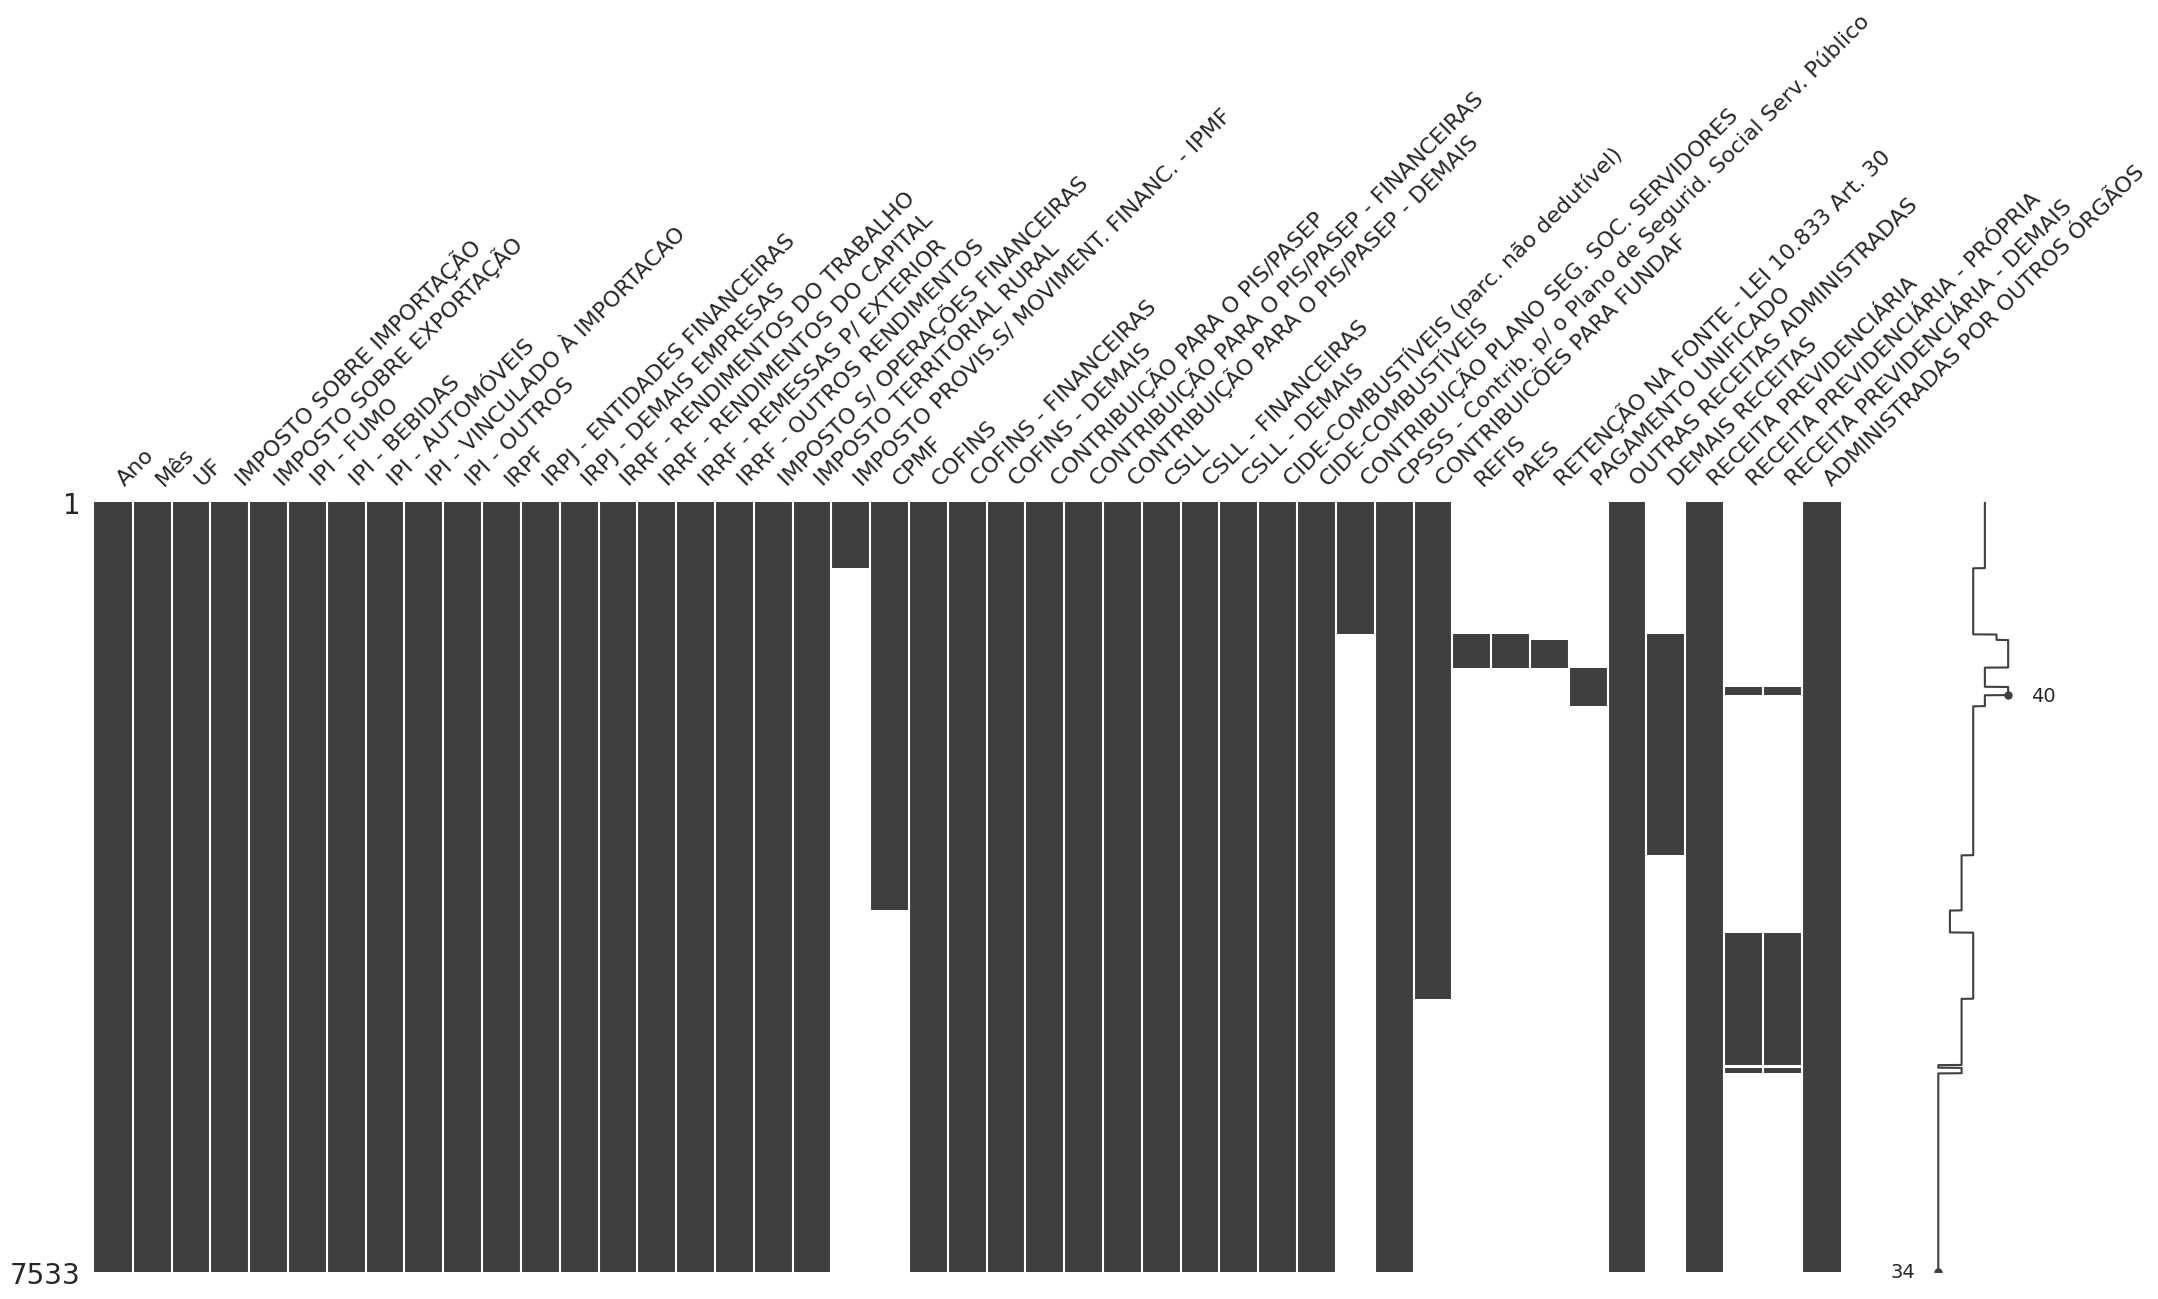

In [287]:
#Verificando matriz de valores nulos do dataset
ms.matrix(arrecadacao_backup)

Nessa matriz, podemos perceber claramente que os missings ainda presentes se estender até os períodos mais recentes.

Dessa maneira, tratam-se de registros que não são mais realizados e, portanto, não devem ser tratados no modelo de projeção de receitas.

Conforme, verficado anteriormente, identificamos a possibilidade de transformar o dado categórico do mês em um formato numérico.

Para isso, criamos um dicionário dos meses e fizemos uma iteração no total das linhas do dataset alterando os registros, de acordo com os valores do dicionário.

Além disso, criamos o atributo "DATA", em formato datetime, unindo as colunas de "Ano" e "Mês", para, eventualmente, utilizar comparações por datas.

In [288]:
#Convertendo dados do mês para formato numérico.
conversao_mes: dict = {'Janeiro': 1, 'Fevereiro': 2, 'Março': 3, 'Abril': 4, 'Maio': 5, 'Junho': 6, 'Julho': 7, 'Agosto': 8, 'Setembro': 9, 'Outubro': 10, 'Novembro': 11, 'Dezembro': 12}
arrecadacao_backup['DATA'] = range(0, 7533)
for i,j in enumerate(arrecadacao_backup['Ano']):
    arrecadacao_backup['Mês'][i] = conversao_mes[arrecadacao_backup['Mês'][i]]
    arrecadacao_backup['DATA'][i] = dt.strptime('1' + '/' + str(arrecadacao_backup['Mês'][i]) + '/' + str(j), '%d/%m/%Y').date()
arrecadacao_backup['Mês'] = pd.to_numeric(arrecadacao_backup['Mês'])

#Verificando alteração do tipo de dado
arrecadacao_backup.dtypes

<ipython-input-288-b0dddfb968b3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrecadacao_backup['Mês'][i] = conversao_mes[arrecadacao_backup['Mês'][i]]
<ipython-input-288-b0dddfb968b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrecadacao_backup['DATA'][i] = dt.strptime('1' + '/' + str(arrecadacao_backup['Mês'][i]) + '/' + str(j), '%d/%m/%Y').date()


Ano                                                               int64
Mês                                                               int64
UF                                                               object
IMPOSTO SOBRE IMPORTAÇÃO                                          int64
IMPOSTO SOBRE EXPORTAÇÃO                                          int64
IPI - FUMO                                                        int64
IPI - BEBIDAS                                                     int64
IPI - AUTOMÓVEIS                                                  int64
IPI - VINCULADO À IMPORTACAO                                      int64
IPI - OUTROS                                                      int64
IRPF                                                              int64
IRPJ - ENTIDADES FINANCEIRAS                                      int64
IRPJ - DEMAIS EMPRESAS                                            int64
IRRF - RENDIMENTOS DO TRABALHO                                  

Identifica-se que a alteração do tipo de dado da coluna "Mês" foi realizada.

> Agregando colunas

Foi identificado que algumas colunas foram segregadas ao longo do tempo em função de mudanças de critérios de arrecadação. Dessa forma, para garantir a uniformidade da análise, as mesmas foram agrupadas novamente.

In [289]:
arrecadacao_backup['CONTRIBUIÇÃO PARA O PIS/PASEP'] = arrecadacao_backup['CONTRIBUIÇÃO PARA O PIS/PASEP'] + arrecadacao_backup['CONTRIBUIÇÃO PARA O PIS/PASEP - FINANCEIRAS'] + arrecadacao_backup['CONTRIBUIÇÃO PARA O PIS/PASEP - DEMAIS']
arrecadacao_backup['IPI'] = arrecadacao_backup['IPI - FUMO'] + arrecadacao_backup['IPI - BEBIDAS'] + arrecadacao_backup['IPI - AUTOMÓVEIS'] + arrecadacao_backup['IPI - VINCULADO À IMPORTACAO'] + arrecadacao_backup['IPI - OUTROS']
arrecadacao_backup['IRPJ'] = arrecadacao_backup['IRPJ - ENTIDADES FINANCEIRAS'] +  arrecadacao_backup['IRPJ - DEMAIS EMPRESAS']
arrecadacao_backup['IRRF'] = arrecadacao_backup['IRRF - RENDIMENTOS DO TRABALHO'] + arrecadacao_backup['IRRF - RENDIMENTOS DO CAPITAL'] + arrecadacao_backup['IRRF - REMESSAS P/ EXTERIOR'] + arrecadacao_backup['IRRF - OUTROS RENDIMENTOS']
arrecadacao_backup['CSLL'] = arrecadacao_backup['CSLL'] + arrecadacao_backup['CSLL - DEMAIS'] + arrecadacao_backup['CSLL - FINANCEIRAS']
arrecadacao_backup['COFINS'] = arrecadacao_backup['COFINS - FINANCEIRAS'] + arrecadacao_backup['COFINS'] + arrecadacao_backup['COFINS - DEMAIS']
arrecadacao_backup['CIDE-COMBUSTÍVEIS'] = arrecadacao_backup['CIDE-COMBUSTÍVEIS'] + arrecadacao_backup['CIDE-COMBUSTÍVEIS (parc. não dedutível)']

#Conferindo se ocorreu algum erro na agregação
arrecadacao_backup.isnull().sum()

Ano                                                                0
Mês                                                                0
UF                                                                 0
IMPOSTO SOBRE IMPORTAÇÃO                                           0
IMPOSTO SOBRE EXPORTAÇÃO                                           0
IPI - FUMO                                                         0
IPI - BEBIDAS                                                      0
IPI - AUTOMÓVEIS                                                   0
IPI - VINCULADO À IMPORTACAO                                       0
IPI - OUTROS                                                       0
IRPF                                                               0
IRPJ - ENTIDADES FINANCEIRAS                                       0
IRPJ - DEMAIS EMPRESAS                                             0
IRRF - RENDIMENTOS DO TRABALHO                                     0
IRRF - RENDIMENTOS DO CAPITAL     

> Eliminando colunas desnecessárias

Foi identificada na matriz do dataset um conjunto de colunas que não contribuem para a o modelo que se pretende construir. Referem-se a colunas que foram agregadas no primeiro pré-processamento, tributos extintos, ou critérios de arrecadação temporários.

<Axes: >

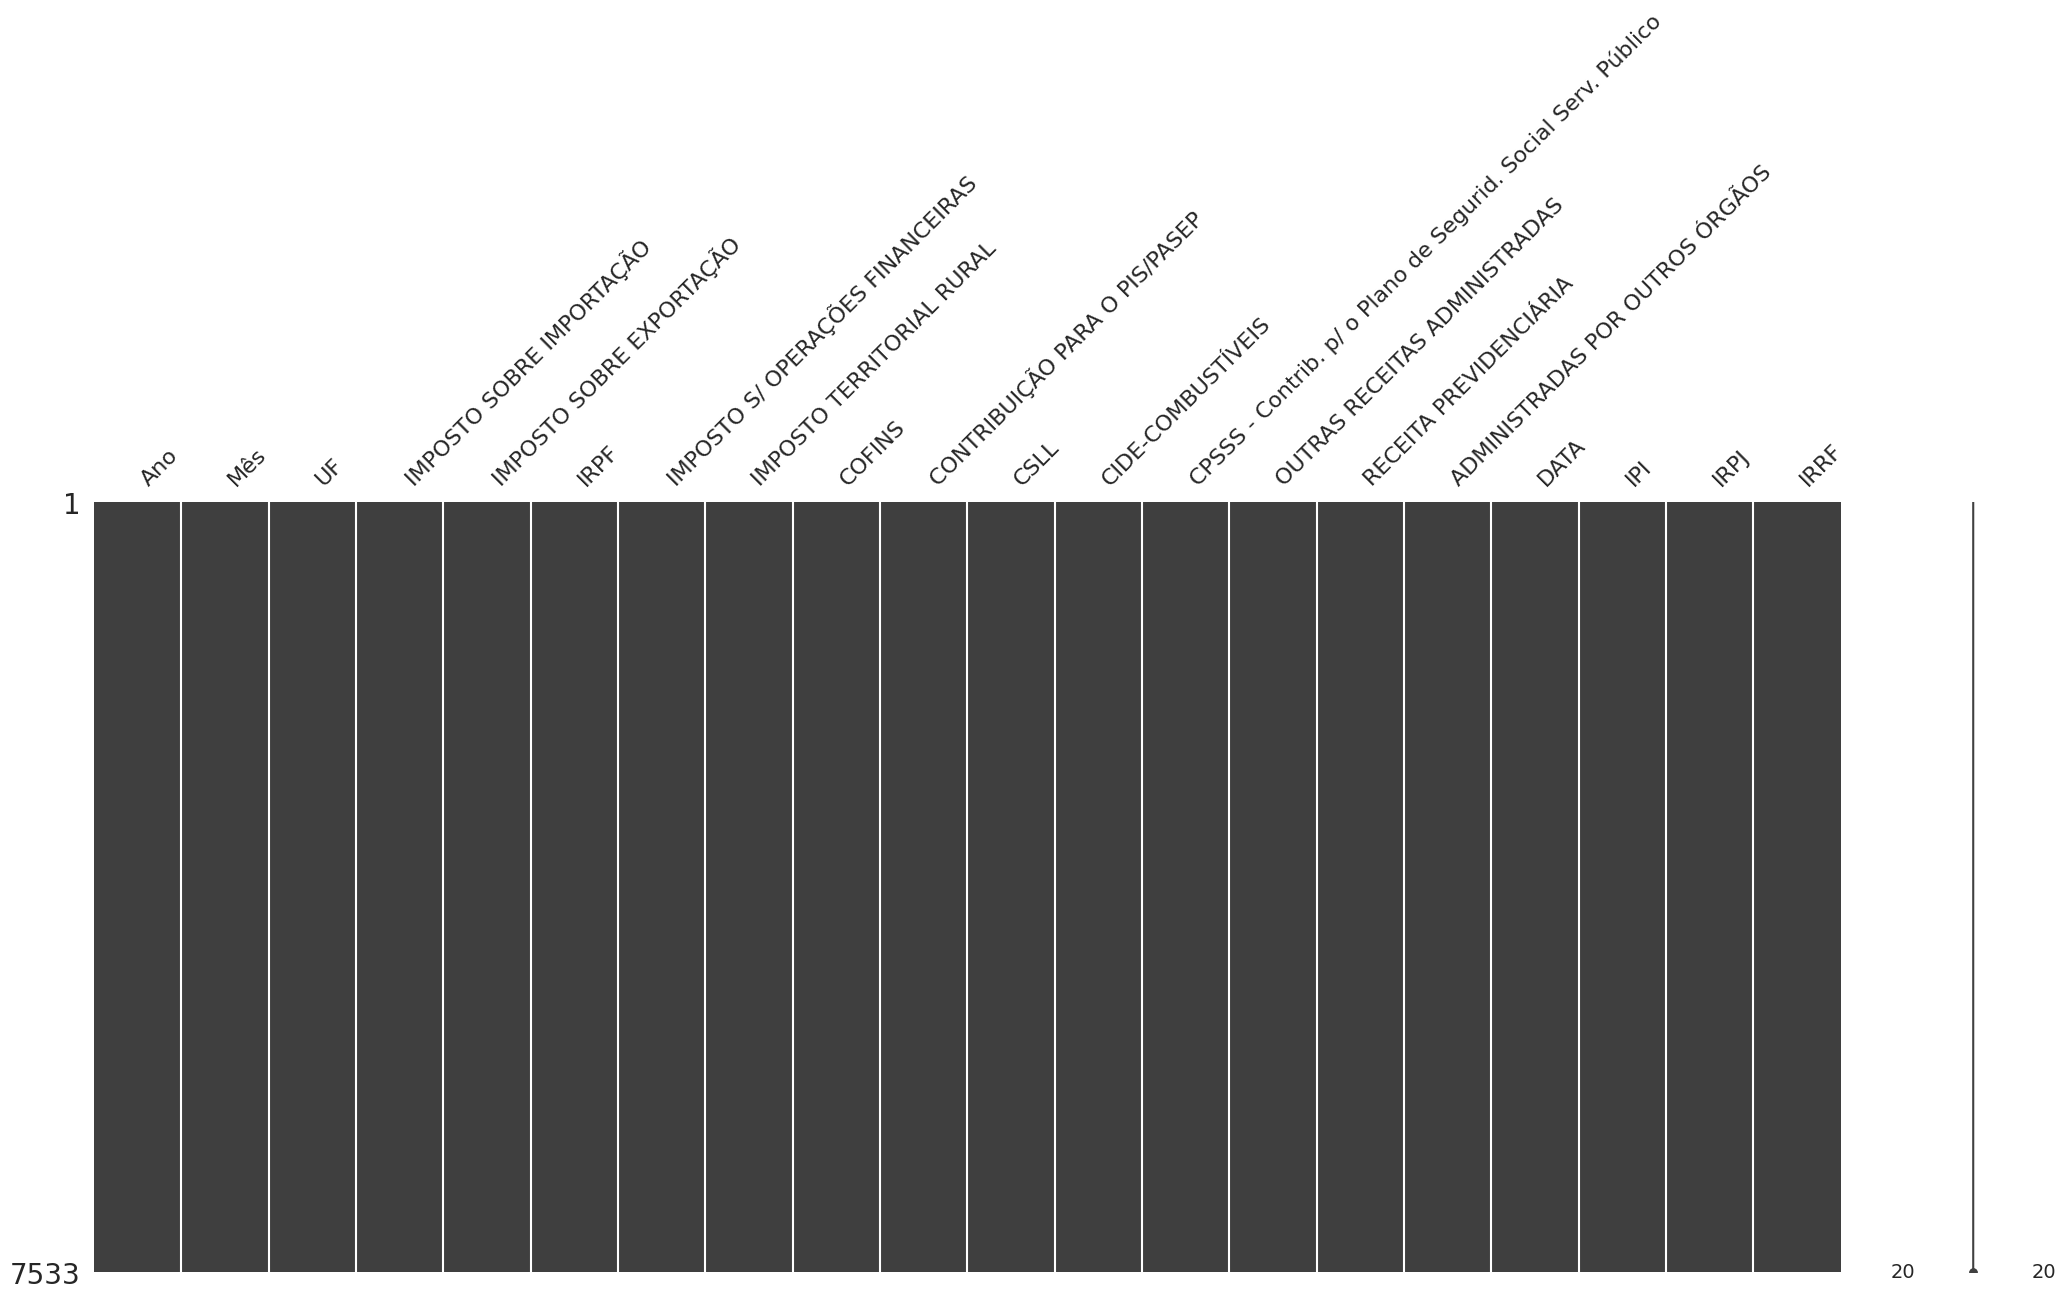

In [290]:
#Removendo colunas
arrecadacao_backup = arrecadacao_backup.drop(columns=['IMPOSTO PROVIS.S/ MOVIMENT. FINANC. - IPMF', 'CPMF', 'CONTRIBUIÇÃO PARA O PIS/PASEP - FINANCEIRAS', 'CONTRIBUIÇÃO PARA O PIS/PASEP - DEMAIS', 'IPI - FUMO', 'IPI - BEBIDAS', 'IPI - AUTOMÓVEIS', 'IPI - VINCULADO À IMPORTACAO', 'IPI - OUTROS', 'IRPJ - ENTIDADES FINANCEIRAS', 'IRPJ - DEMAIS EMPRESAS', 'IRRF - RENDIMENTOS DO TRABALHO', 'IRRF - RENDIMENTOS DO CAPITAL', 'IRRF - REMESSAS P/ EXTERIOR', 'IRRF - OUTROS RENDIMENTOS', 'CSLL - DEMAIS', 'CSLL - FINANCEIRAS', 'COFINS - FINANCEIRAS', 'COFINS - DEMAIS', 'CIDE-COMBUSTÍVEIS (parc. não dedutível)', 'CONTRIBUICÕES PARA FUNDAF', 'DEMAIS RECEITAS', 'RECEITA PREVIDENCIÁRIA - PRÓPRIA', 'RECEITA PREVIDENCIÁRIA - DEMAIS', 'PAGAMENTO UNIFICADO', 'REFIS', 'PAES', 'RETENÇÃO NA FONTE - LEI 10.833 Art. 30', 'CONTRIBUIÇÃO PLANO SEG. SOC. SERVIDORES'])

#Conferindo reflexos da alteração no dataset
ms.matrix(arrecadacao_backup)

Percebe-se que já não constam mais *missings* ou valores nulos no dataset.

Com as alterações realizadas, voltaremos a analisar o conjunto dos dados.

# Reanalisando dados

Nessa etapa iremos projetar algumas visões para o conjunto tratado do dataset, visando obter novos insights ou a necessidade de novos tratamentos.

Começaremos com uma visão agrupada por Ano e Unidade Federativa da média dos valores arrecadados para termos uma primeira referência.

In [291]:
#Verificando o média anual por Unidade Federativa dos valores arrecadados.
arrecadacao_backup.groupby(['Ano', 'UF']).mean(numeric_only=True)

Mês  IMPOSTO SOBRE IMPORTAÇÃO  IMPOSTO SOBRE EXPORTAÇÃO  \
Ano  UF                                                            
2000 AC  6.5              8.135833e+02              1.083333e+00   
     AL  6.5              5.699383e+05              1.908550e+04   
     AM  6.5              1.367492e+07              5.891667e+01   
     AP  6.5              3.962717e+04              0.000000e+00   
     BA  6.5              1.486155e+07              9.242500e+02   
...      ...                       ...                       ...   
2023 RS  2.0              1.092364e+09              8.228733e+04   
     SC  2.0              6.540383e+09              7.827063e+05   
     SE  2.0              8.525544e+08             -4.445530e+05   
     SP  2.0              1.263729e+09              7.186953e+07   
     TO  2.0              2.239535e+08             -1.600000e+01   

                 IRPF  IMPOSTO S/ OPERAÇÕES FINANCEIRAS  \
Ano  UF                                                   
2000 AC  4.018123e+05                      1.524917e+03   
     AL  1.498026e+06                      1.230083e+04   
     AM  1.725184e+06                      1.118547e+06   
     AP  3.602833e+05                      1.682000e+03   
     BA  6.088068e+06                      2.373709e+06   
...               ...                               ...   
2023 RS  1.130762e+09                      1.093896e+09   
     SC  6.757695e+09                      6.226650e+09   
     SE  3.434387e+09                      1.401929e+09   
     SP  3.632546e+09                      2.421926e+09   
     TO  6.311650e+08                      4.871494e+07   

         IMPOSTO TERRITORIAL RURAL        COFINS  \
Ano  UF                                            
2000 AC               3.599075e+04  1.553726e+06   
     AL               4.456512e+05  8.391335e+06   
     AM               3.139158e+04  5.660133e+07   
     AP               1.838167e+04  1.525273e+06   
     BA               8.913393e+05  8.129811e+07   
...                            ...           ...   
2023 RS               1.136134e+08  2.772466e+09   
     SC               1.077362e+08  2.173994e+09   
     SE               2.508678e+08  8.403296e+09   
     SP               4.337960e+08  1.252138e+10   
     TO               1.434422e+08  4.285321e+09   

         CONTRIBUIÇÃO PARA O PIS/PASEP          CSLL  CIDE-COMBUSTÍVEIS  \
Ano  UF                                                                   
2000 AC                   4.146152e+05  4.211294e+05       0.000000e+00   
     AL                   2.464731e+06  1.508343e+06       0.000000e+00   
     AM                   1.437662e+07  1.900616e+07       0.000000e+00   
     AP                   5.612035e+05  3.758642e+05       0.000000e+00   
     BA                   2.025471e+07  1.754242e+07       0.000000e+00   
...                                ...           ...                ...   
2023 RS                   3.220868e+09  3.309696e+09       2.703667e+03   
     SC                   2.143370e+09  2.853705e+09       1.988970e+05   
     SE                   3.512646e+09  3.331421e+09       5.664887e+06   
     SP                   4.016492e+09  8.874245e+09       6.779936e+06   
     TO                   1.913247e+09  2.986060e+09       2.427567e+04   

         CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público  \
Ano  UF                                                                 
2000 AC                                       1.805425e+09              
     AL                                       1.805425e+09              
     AM                                       1.805425e+09              
     AP                                       1.805425e+09              
     BA                                       1.805425e+09              
...                                                    ...              
2023 RS                                       1.333540e+09              
     SC                                       

Variação das médias demonstra a discrepância entre a arrecadação dos estados.

Faremos uma nova análise, dessa vez, agrupada por Unidade Federativa, ano e Mês do total de valores arrecadados de cada rubrica do dataset.

In [292]:
#Verificando total de arrecadação por Unidade Federativa, Ano e Mês
arrecadacao_backup.groupby(['UF', 'Ano', 'Mês']).sum(numeric_only=True)

IMPOSTO SOBRE IMPORTAÇÃO  IMPOSTO SOBRE EXPORTAÇÃO        IRPF  \
UF Ano  Mês                                                                   
AC 2000 1                         231                         0      177197   
        2                         441                         0      144788   
        3                        2648                         0      127554   
        4                          69                         0     1534469   
        5                         349                         0      516710   
...                               ...                       ...         ...   
TO 2022 11                       4249                     14995  1407440747   
        12                          0                         0  1335913422   
   2023 1                   317412404                       -44   703021876   
        2                   329789178                        -4   487627929   
        3                    24659064                         0   702845126   

             IMPOSTO S/ OPERAÇÕES FINANCEIRAS  IMPOSTO TERRITORIAL RURAL  \
UF Ano  Mês                                                                
AC 2000 1                                1220                      28447   
        2                                1447                       1948   
        3                                 956                       3504   
        4                                 602                       2826   
        5                                 749                     159019   
...                                       ...                        ...   
TO 2022 11                           51897923                  463422467   
        12                           54427746                   38139747   
   2023 1                            45659272                  113203521   
        2                            39445365                  166736976   
        3                            61040181                  150386153   

                   COFINS  CONTRIBUIÇÃO PARA O PIS/PASEP          CSLL  \
UF Ano  Mês                                                              
AC 2000 1    1.770475e+06                   3.873640e+05  3.928300e+05   
        2    1.389041e+06                   3.962280e+05  2.167060e+05   
        3    1.419197e+06                   4.107170e+05  2.250860e+05   
        4    1.290412e+06                   3.019530e+05  3.925410e+05   
        5    1.265317e+06                   4.301890e+05  3.237780e+05   
...                   ...                            ...           ...   
TO 2022 11   4.046294e+09                   1.825241e+09  2.203894e+09   
        12   4.100781e+09                   2.009764e+09  1.933934e+08   
   2023 1    4.700987e+09                   2.178246e+09  4.024510e+09   
        2    4.097737e+09                   1.836479e+09  3.028287e+09   
        3    4.057239e+09                   1.725017e+09  1.905384e+09   

             CIDE-COMBUSTÍVEIS  \
UF Ano  Mês                      
AC 2000 1                  0.0   
        2                  0.0   
        3                  0.0   
        4                  0.0   
        5                  0.0   
...                        ...   
TO 2022 11                 0.0   
        12                 0.0   
   2023 1                983.0   
        2                316.0   
        3              71528.0   

             CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público  \
UF Ano  Mês                                                                 
AC 2000 1                                         1.805425e+09              
        2                                         1.805425e+09              
        3                                         1.805425e+09              
        4                                         1.805425e+09              
        5                                         1.805425e+09              
...                                                

Vê-se que os dados mais recentes da arrecadação podem estar desatualizados. Há muita diferença de valores entre os últimos meses, sem justificativa aparente.

Observemos o resumo estatístico do dataframe tratado.

In [293]:
#Revisando estatísticas do dataframe após o primeiro tratamento
arrecadacao_backup.describe()

,Ano,Mês,IMPOSTO SOBRE IMPORTAÇÃO,IMPOSTO SOBRE EXPORTAÇÃO,IRPF,IMPOSTO S/ OPERAÇÕES FINANCEIRAS,IMPOSTO TERRITORIAL RURAL,COFINS,CONTRIBUIÇÃO PARA O PIS/PASEP,CSLL,CIDE-COMBUSTÍVEIS,CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público,OUTRAS RECEITAS ADMINISTRADAS,RECEITA PREVIDENCIÁRIA,ADMINISTRADAS POR OUTROS ÓRGÃOS,IPI,IRPJ,IRRF
count,7533.000000,7533.000000,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03
mean,2011.129032,6.451613,1.034112e+09,3.202691e+06,1.369203e+09,6.804114e+08,1.400058e+08,2.582228e+09,1.827617e+09,1.923389e+09,1.771796e+08,2.110562e+09,9.241200e+08,3.356289e+09,2.226673e+09,2.664591e+09,2.280346e+09,3.725068e+09
std,6.713017,3.465933,2.091124e+09,2.543243e+07,2.091944e+09,1.622515e+09,5.997289e+08,3.185302e+09,2.650572e+09,2.777888e+09,7.176899e+08,1.639038e+09,1.840472e+09,1.684271e+09,2.031487e+09,5.118571e+09,3.102991e+09,5.165441e+09
min,2000.000000,1.000000,-1.792566e+07,-9.155959e+07,1.228300e+04,-2.689010e+05,-1.775623e+08,1.049745e+06,5.564300e+04,2.540000e+02,-3.652861e+08,2.461105e+06,-1.991267e+10,3.446879e+07,-5.810897e+09,-9.132174e+07,3.037600e+04,-1.307314e+07
25%,2005.000000,3.000000,1.357881e+06,0.000000e+00,8.080265e+06,9.810910e+05,2.879980e+05,7.419200e+07,2.163285e+07,2.078322e+07,0.000000e+00,1.612286e+09,1.964925e+06,3.114104e+09,1.567679e+09,1.009030e+07,3.074382e+07,3.344381e+07
50%,2011.000000,6.000000,3.249109e+07,3.074000e+03,3.090043e+08,2.517404e+07,5.117547e+06,1.198334e+09,5.725987e+08,5.712251e+08,0.000000e+00,1.805425e+09,1.032554e+08,3.114104e+09,1.765880e+09,2.396761e+08,9.332323e+08,1.145766e+09
75%,2017.000000,9.000000,9.299352e+08,2.303110e+05,1.907351e+09,4.630131e+08,4.244567e+07,4.198346e+09,2.552672e+09,2.754779e+09,7.392380e+05,2.000212e+09,9.923987e+08,3.114104e+09,1.964983e+09,1.690438e+09,3.382466e+09,5.699005e+09
max,2023.000000,12.000000,9.978470e+09,1.557215e+09,9.999580e+09,9.931804e+09,9.861882e+09,2.103176e+10,1.870852e+10,1.907118e+10,9.079891e+09,9.989391e+09,2.289754e+10,2.778681e+10,2.247643e+10,3.382251e+10,2.658539e+10,3.005982e+10


Vemos que os valores máximos da arrecadação de alguns tributos são próximos.
Não identificado o porquê de alguns tributos terem o primeiro quartil igual a zero, após o tratamento dado.

Passemos agora a avaliar visualmente o conjunto de informações.

# Visualização dos dados

Para a etapa de visualização dos dados, optamos por alguns tipos de gráficos mais apropriados para o cenário que estamos tratando.
Trabalharemos com boxplots, scatterplots, gráficos de linhas e mapas de calor

> Boxplots

Buscamos verificar a distribuição dos valores para todos os atributos do dataser e possíveis outliers.



Text(0.5, 1.0, 'ADM. POR OUTROS')

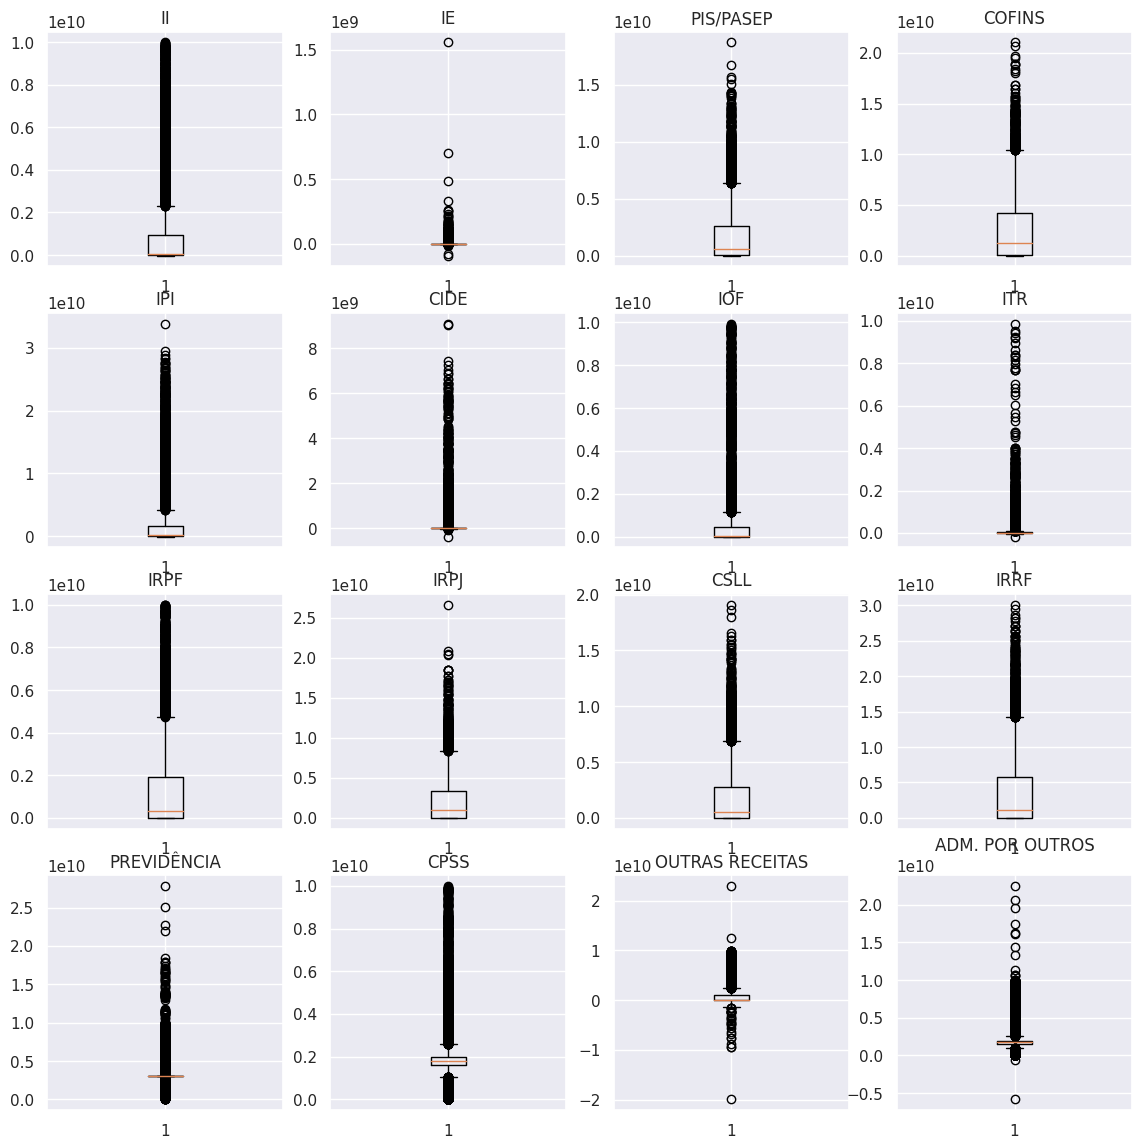

In [294]:
#Analisando a distribuição dos valores por cada atributo do dataset

# configurando um grupo de subplots em um grid de 4 linhas e 4 colunas e também o tamanho da figura
fig, ax = plt.subplots(4,4, figsize = (14, 14)) 

# subplot1: boxplot do II
ax[0,0].boxplot(arrecadacao_backup['IMPOSTO SOBRE IMPORTAÇÃO'])
ax[0,0].set_title("II")

# subplot2: boxplot do IE
ax[0,1].boxplot(arrecadacao_backup['IMPOSTO SOBRE EXPORTAÇÃO'])
ax[0,1].set_title("IE")

# subplot3: boxplot do PIS/PASEP
ax[0,2].boxplot(arrecadacao_backup['CONTRIBUIÇÃO PARA O PIS/PASEP'])
ax[0,2].set_title("PIS/PASEP")

# subplot4: boxplot do COFINS
ax[0,3].boxplot(arrecadacao_backup['COFINS'])
ax[0,3].set_title("COFINS")

# subplot5: boxplot do IPI
ax[1,0].boxplot(arrecadacao_backup['IPI'])
ax[1,0].set_title("IPI")

# subplot6: boxplot do CIDE
ax[1,1].boxplot(arrecadacao_backup['CIDE-COMBUSTÍVEIS'])
ax[1,1].set_title("CIDE")

# subplot7: boxplot dos IOF
ax[1,2].boxplot(arrecadacao_backup['IMPOSTO S/ OPERAÇÕES FINANCEIRAS'])
ax[1,2].set_title("IOF")

# subplot8: boxplot dos ITR
ax[1,3].boxplot(arrecadacao_backup['IMPOSTO TERRITORIAL RURAL'])
ax[1,3].set_title("ITR")

# subplot9: boxplot do IRPF
ax[2,0].boxplot(arrecadacao_backup['IRPF'])
ax[2,0].set_title("IRPF")

# subplot10: boxplot do IRPJ
ax[2,1].boxplot(arrecadacao_backup['IRPJ'])
ax[2,1].set_title("IRPJ")

# subplot11: boxplot dos CSLL
ax[2,2].boxplot(arrecadacao_backup['CSLL'])
ax[2,2].set_title("CSLL")

# subplot12: boxplot dos IRRF
ax[2,3].boxplot(arrecadacao_backup['IRRF'])
ax[2,3].set_title("IRRF")

# subplot13: boxplot do RECEITA PREVIDENCIÁRIA
ax[3,0].boxplot(arrecadacao_backup['RECEITA PREVIDENCIÁRIA'])
ax[3,0].set_title("PREVIDÊNCIA")

# subplot14: boxplot do CPSSS
ax[3,1].boxplot(arrecadacao_backup['CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público'])
ax[3,1].set_title("CPSS")

# subplot15: boxplot dos OUTRAS RECEITAS ADMINISTRADAS
ax[3,2].boxplot(arrecadacao_backup['OUTRAS RECEITAS ADMINISTRADAS'])
ax[3,2].set_title("OUTRAS RECEITAS")

# subplot16: boxplot dos ADMINISTRADAS POR OUTROS ÓRGÃOS
ax[3,3].boxplot(arrecadacao_backup['ADMINISTRADAS POR OUTROS ÓRGÃOS'])
ax[3,3].set_title("ADM. POR OUTROS")

Foram testados diferentes visões do dataframe, porém a distribuição manteve-se com comportamento atípico. Seria necessário mais avaliações para compreender o comportamento da distribuição.



> Scatterplot


A análise dos gráficos de scatter apresentam desempenho lento e há poucos casos em que a relação entre os tributos se faça necessária.

O gráfico demonstra a relação entre o IRPJ e a CSLL, dois tributos incidentes sobre a renda das Pessoas Jurídicas.

Text(0, 0.5, 'CSLL')

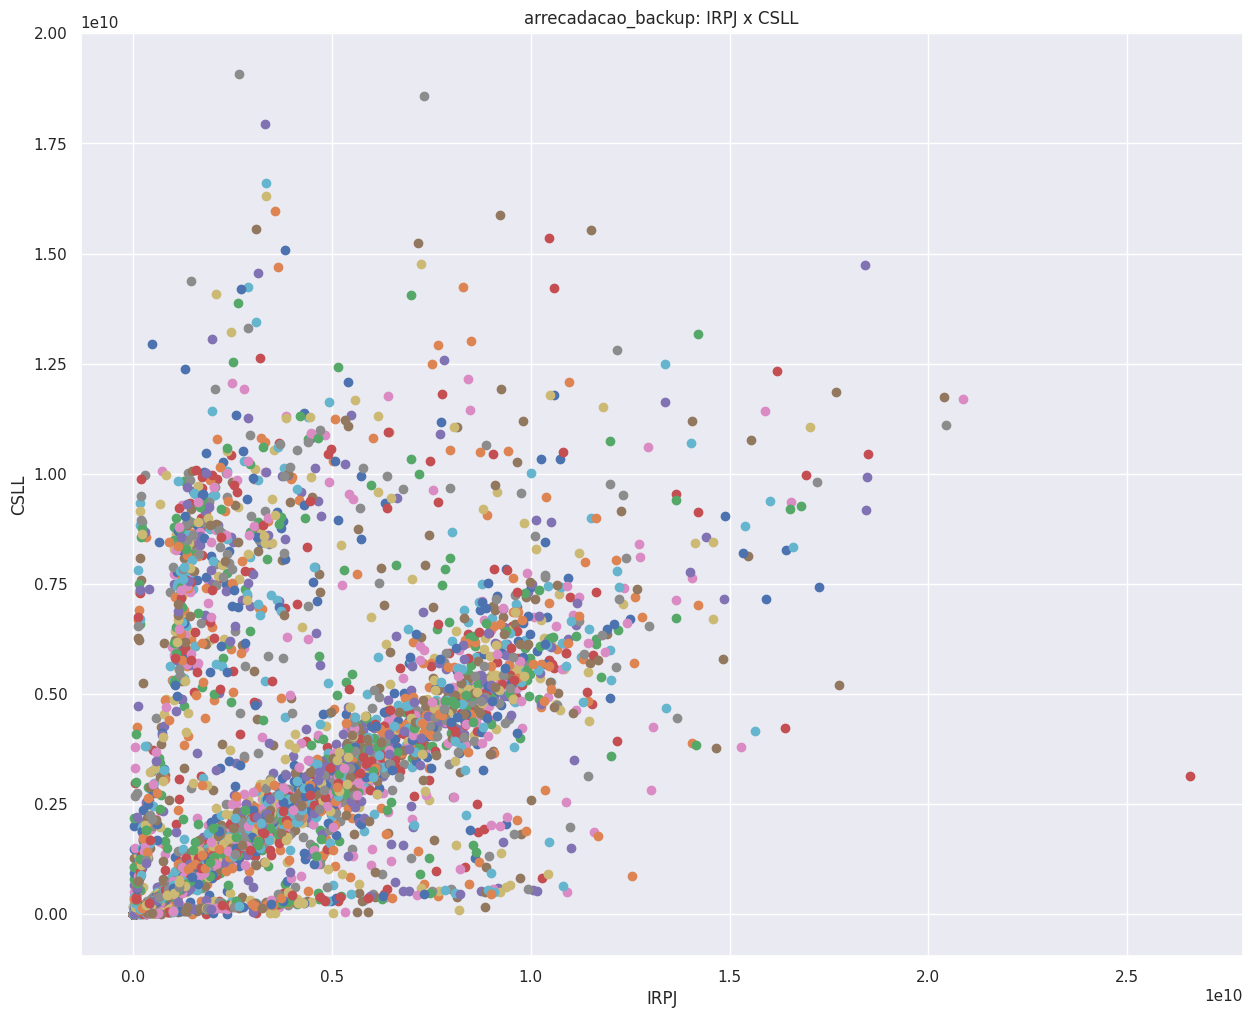

In [295]:
for i in range(len(arrecadacao_backup['UF'])):
    plt.scatter(arrecadacao_backup['IRPJ'][i], arrecadacao_backup['CSLL'][i])

# incluindo título do gráfico e rótulos dos eixos
plt.title('arrecadacao_backup: IRPJ x CSLL')
plt.xlabel('IRPJ')
plt.ylabel('CSLL')

O resultado demonstra uma relação aparentemente equilibrada, algo previsível, dado que os dois tributos tem base de cálculo e alíquotas semelhantes.



> Gráfico de Linhas

Utilzamos o gráfico de linhas para verificar a variação anual da distribuição do Impostos sobre Importação e sobre Exportação.


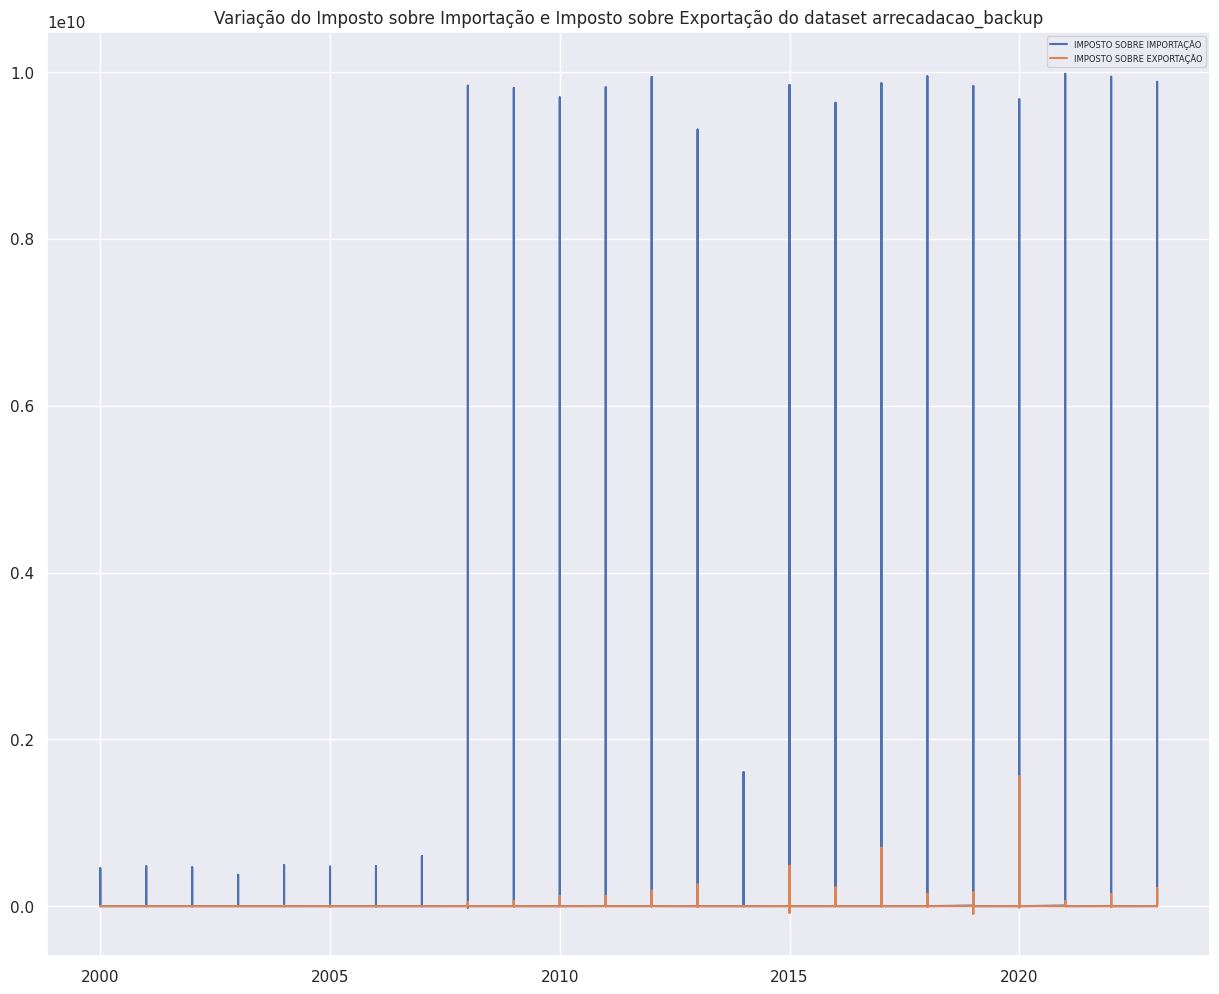

In [296]:
# selecionando apenas os atributos para serem plotados
atributos = ['IMPOSTO SOBRE IMPORTAÇÃO', 'IMPOSTO SOBRE EXPORTAÇÃO']

# criando o eixo x - vai de do ano 2000 até 2023
x_data = arrecadacao_backup['Ano']

# plotando cada atributo
for atributo in atributos: 
    plt.plot(x_data, arrecadacao_backup[atributo], label=atributo)
    
# incluindo título do gráfico e legenda
plt.title('Variação do Imposto sobre Importação e Imposto sobre Exportação do dataset arrecadacao_backup')
plt.legend(fontsize=6, loc='best')

Identifica-se que a discrepância entre os dois impostos é coerente, dado o governo estabelece política de incentivos as exportações, reduzindo a tributação sobre essas operações.



> Heatmap

Apresentamos o mapa de calor para identificar o grau de relação entre os atributos do dataset.



<ipython-input-297-715f665cbc75>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(arrecadacao_backup.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1)


<Axes: >

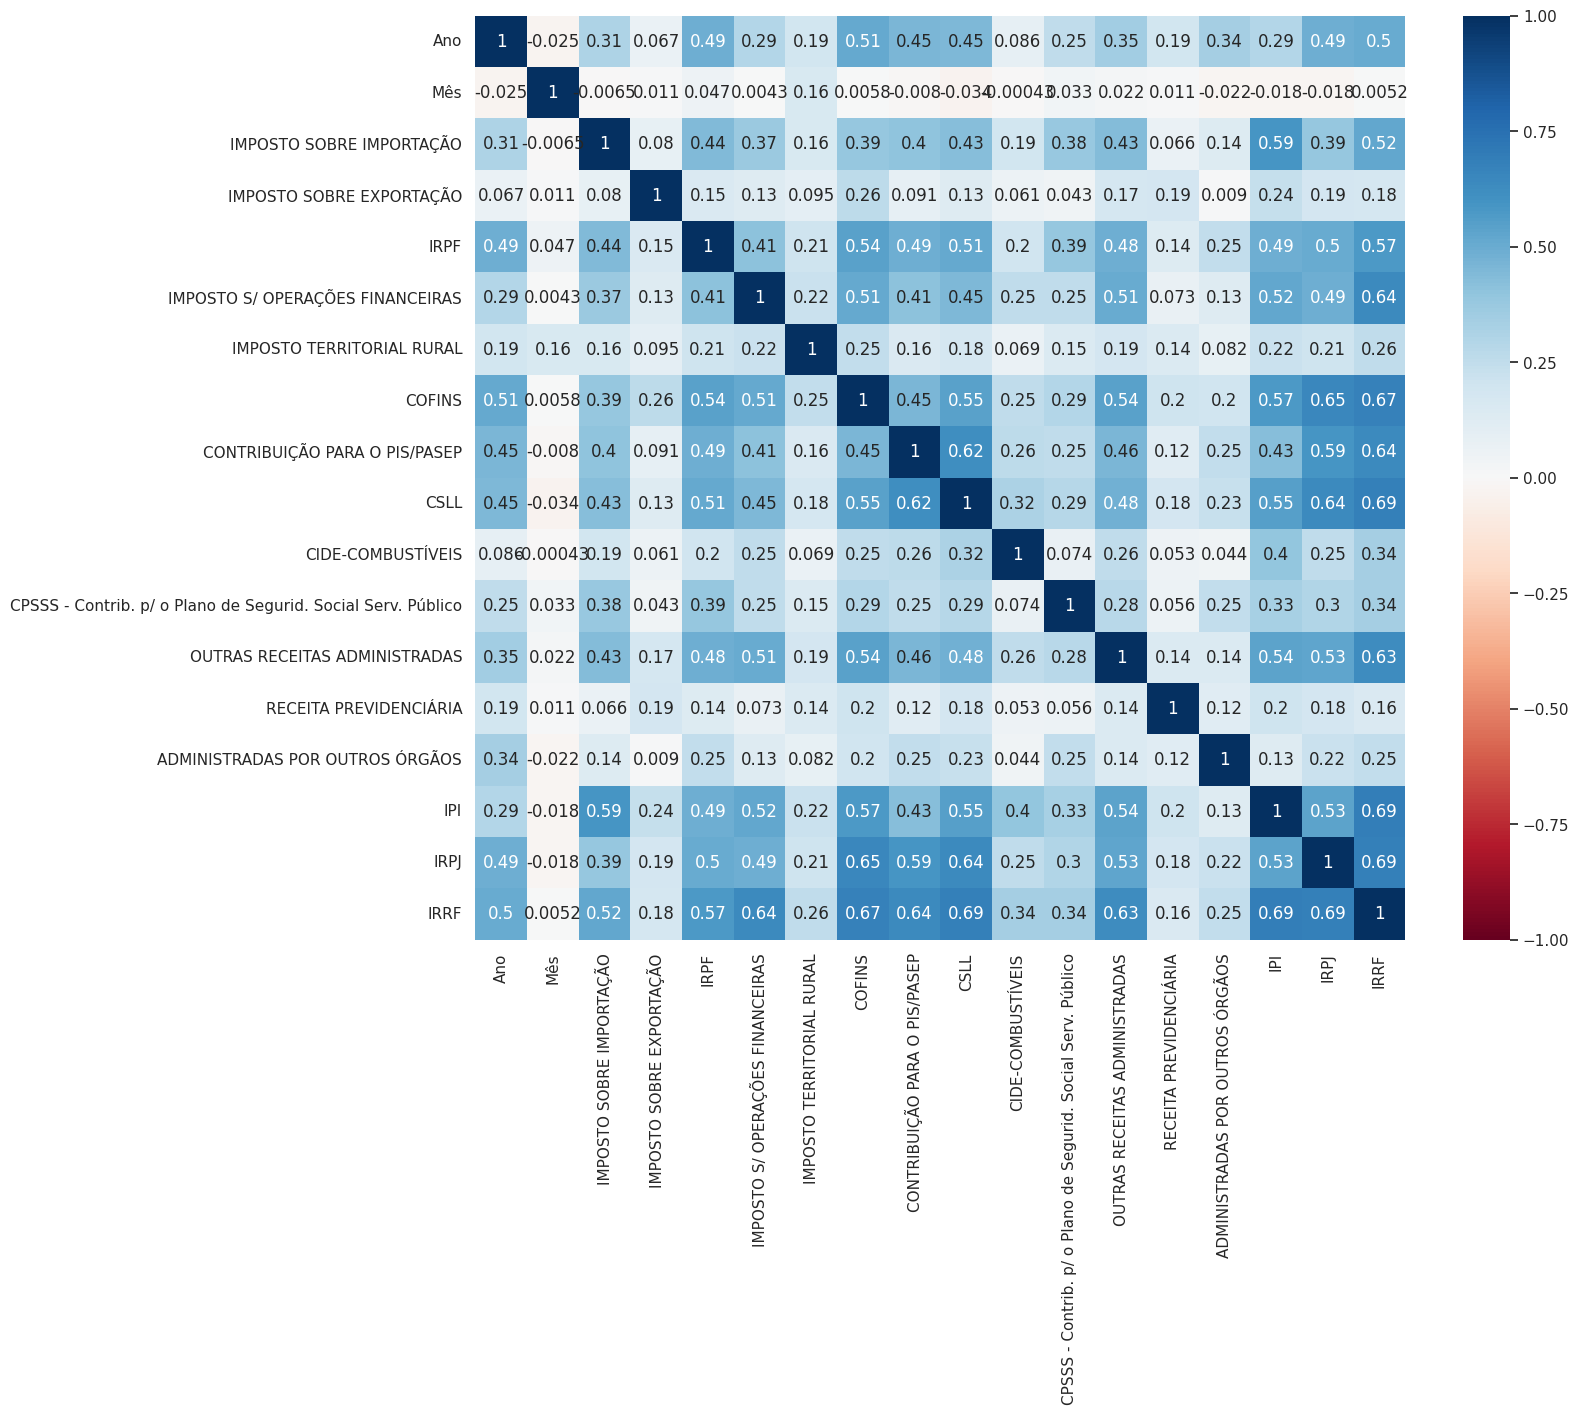

In [297]:
#Avaliando a relação entre os tributos
sns.set(rc = {'figure.figsize':(15,12)})
sns.heatmap(arrecadacao_backup.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1)

A distribuição aponta que o IRRF apresenta uma quantidade maior de relações mais altas. 

Além disso, verifica-se que não há relações negativas.

Dadas essas visões, façamos um novo exercício de pré-processamento

# Segundo pré-processamento

Nesse momento, trabalharemos com transformações numéricas do dataset, para preparar os dados para a etapa de treinamento.

Para isso, começaremos mantendo uma cópia da base de dados antes dos tratamento e ajustes prévios necessários para as transformações.

In [298]:
#Segregando amostras do dataset para testes e treinamento.
amostra = arrecadacao_backup

#Excluindo coluna com tipo de dados divergente
amostra = amostra.drop(columns=['DATA'])



> Segregação da amostra


Para segregação da amostra, seria necessário a aplicação de técnicas de validação cruzada. Mas, em virtude da indefinição da forma de saída pretendida pelo modelo, esse processo ainda não foi realizado.

Temos dúvidas se a saída deva conter a totalização dos valores arrecadados anuais, mensais, por estado, por cada atributo ou apenas o total anual bruto da arrecadação prevista.

Para fins de exercício, realizamos os tratamentos sem a segregação das amostras, mas entendemos que esse trabalho deve ser realizado, quando houver uma definição mais clara sobre o resultado esperado.

Dessa maneira, apenas selecionamos os atributos para tratamento, conforme o tipo de transformação mais adequada.

In [299]:
#Definição do conjunto para transformação.
x = amostra.values[:, 3:19]



> Normalização



A partir da segregação trabalharemos na normalização dos dados. Esse tratamento poderá auxiliar na avaliação da amostra, dado que temos dados negativos que tem afetado as análises.

In [300]:
#Normalizando a distribuição dado que há valores negativos que tem afetado as análises
rescaled_x = MinMaxScaler().fit_transform(x)

# Exibindo os dados transformados
print("Dados Originais: \n\n", x)
print("\nDados Normalizados (não inclui a coluna class): \n\n", rescaled_x)

Dados Originais: 

 [[231 0 177197 ... 293821 677478 1144056]
 [475088 33873 460804 ... 5960390 2672667 5499958]
 [11679405 0 700623 ... 9541242 10149541 16025612]
 ...
 [1792437623 -1309421 8613875468 ... 10007435582 9026933975 20823769771]
 [379440024 214698413 924621042 ... 910274842 3532695545 3413935989]
 [24659064 0 702845126 ... 340676704 322997849 2267485480]]

Dados Normalizados (não inclui a coluna class): 

 [[1.79323512e-03 5.55318852e-02 1.64921125e-05 ... 2.70142180e-03
  2.43405428e-05 4.72757799e-04]
 [1.84073795e-03 5.55524296e-02 4.48540377e-05 ... 2.86850905e-03
  9.93889636e-05 6.17602601e-04]
 [2.96157368e-03 5.55318852e-02 6.88369738e-05 ... 2.97409582e-03
  3.80629280e-04 9.67607322e-04]
 ...
 [1.81101611e-01 5.47377072e-02 8.61423533e-01 ... 2.97776946e-01
  3.39544204e-01 6.92877934e-01]
 [3.97508973e-02 1.85748806e-01 9.24648705e-02 ... 2.95335716e-02
  1.32880114e-01 1.13956755e-01]
 [4.26000764e-03 5.55318852e-02 7.02863207e-02 ... 1.27381196e-02
  1.2148322

Podemos verificar que o processamento da normalização foi realizado com sucesso.



> Padronização



Agora seguimos com a padronização dos dados. Esse tratamento pode auxliar na visão de uma distribuição normal da amostra.

In [301]:
# Padronizando os dados
standared_x = StandardScaler().fit_transform(x)

# Exibindo os dados transformados
print("Dados Originais: \n\n", x)
print("\nDados Padronizados (não inclui a coluna class): \n\n", standared_x)

Dados Originais: 

 [[231 0 177197 ... 293821 677478 1144056]
 [475088 33873 460804 ... 5960390 2672667 5499958]
 [11679405 0 700623 ... 9541242 10149541 16025612]
 ...
 [1792437623 -1309421 8613875468 ... 10007435582 9026933975 20823769771]
 [379440024 214698413 924621042 ... 910274842 3532695545 3413935989]
 [24659064 0 702845126 ... 340676704 322997849 2267485480]]

Dados Padronizados (não inclui a coluna class): 

 [[-0.49455695 -0.12593775 -0.65447083 ... -0.52055042 -0.73471689
  -0.72097848]
 [-0.49432985 -0.12460578 -0.65433525 ... -0.51944329 -0.73407385
  -0.72013514]
 [-0.48897146 -0.12593775 -0.6542206  ... -0.51874366 -0.73166412
  -0.7180973 ]
 ...
 [ 0.36266442 -0.17742744  3.46335894 ...  1.43464498  2.17436524
   3.31043124]
 [-0.31309237  8.31653714 -0.21253494 ... -0.34275832  0.4036211
  -0.06023748]
 [-0.48276403 -0.12593775 -0.31855624 ... -0.45404641 -0.6308359
  -0.28219852]]


Verifica-se que a padronização foi realizada com sucesso.



> Codificação ordinal

Dado que o dataset apresenta apenas um atributo categórico e não ordinal, não essa técnica não foi realizada.





> One-hot-encoding e dummy encoding


Trataremos a única coluna categórica do dataset ("UF") com essas técnicas.

In [302]:
# definindo o transformador como One-hot_encoder
encoder = OneHotEncoder(sparse=False)

#Transformando os dados
one_hot = encoder.fit_transform(amostra.values[:, 2:3])

# exibindo os dados transformados
print("Atributos transformados:")
print(one_hot)

Atributos transformados:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Repetimos o mesmo exercício aplicando o dummy encoding

In [303]:
# definindo o transformador como One-hot_encoder
encoder = OneHotEncoder(sparse=False, drop='first')

#Transformando os dados
dummy = encoder.fit_transform(amostra.values[:, 2:3])

# exibindo os dados transformados
print("Atributos transformados:")
print(one_hot)

Atributos transformados:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
